# Testing DoWhy's Limits

In [65]:
# Imports

import numpy as np
import pandas as pd
from dowhy import CausalModel
import dowhy.datasets

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Instrumental Variable Basic Example

![Instrumental_Variable](./testing_limits_figures/image.png)

### Continuous Variables

In [2]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

#### Without latent variables

- Everything working as expected

In [3]:
# Build dataset
data = pd.DataFrame({
    'U': ability,
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,U,voucher,education,income
0,5.931114,0.389572,10.440532,65.048021
1,4.149697,2.347846,14.171226,79.701272
2,2.527354,1.541087,7.490208,45.820137
3,-0.151945,2.825163,9.495823,50.110063
4,-5.885362,1.771835,2.029278,4.769520


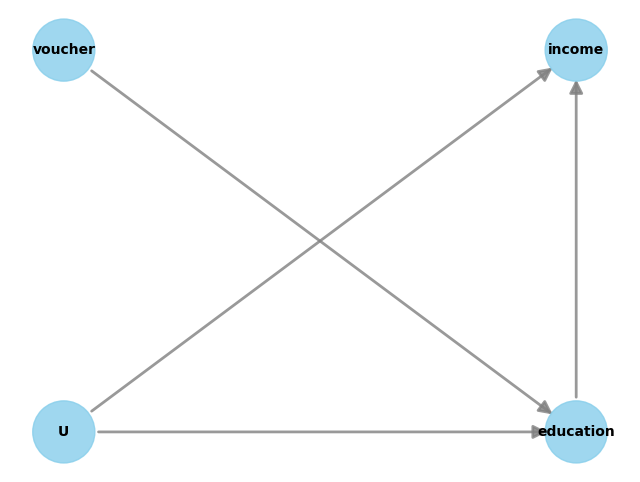

In [4]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [5]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [6]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.058143115039975
New effect:0.013565567904988071
p value:0.76



In [7]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.023590421931993
New effect:-0.0052387181973843535
p value:0.96



#### `Ability` as an unobserved confounder

- Everything working as expected
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [8]:
# Build dataset
data = pd.DataFrame({
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,voucher,education,income
0,0.389572,10.440532,65.048021
1,2.347846,14.171226,79.701272
2,1.541087,7.490208,45.820137
3,2.825163,9.495823,50.110063
4,1.771835,2.029278,4.769520


c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


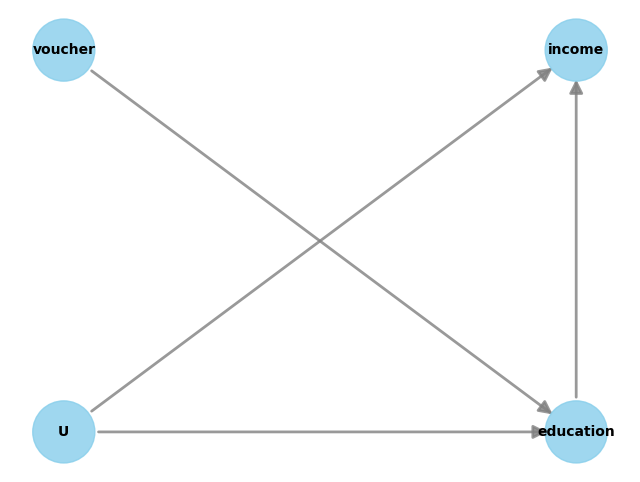

In [9]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [10]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [11]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.023590421931993
New effect:0.044482918788426716
p value:0.8400000000000001



### Discrete Variables

- Function as continuous variables

In [12]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher


# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

#### Without latent variables

- Everything working as expected

In [13]:
# Build dataset
data = pd.DataFrame({
    'U': dowhy.datasets.convert_continuous_to_discrete(ability),
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': dowhy.datasets.convert_continuous_to_discrete(education),
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,U,voucher,education,income
0,-2,0,4,24
1,0,1,6,36
2,1,1,9,52
3,1,0,6,43
4,0,2,9,42


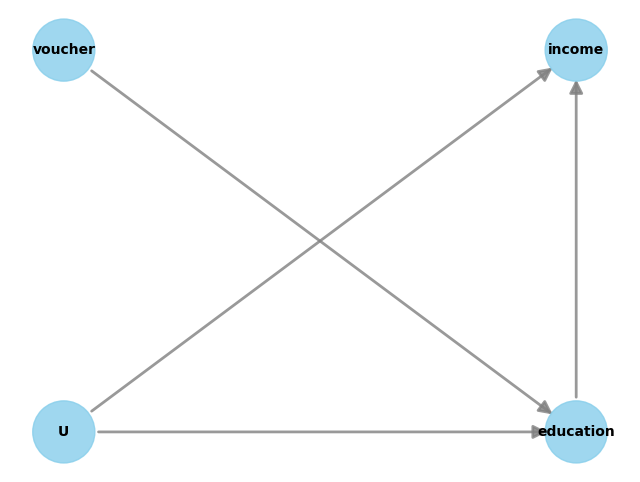

In [14]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [15]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [16]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.946881604538797
New effect:0.0014023223977617505
p value:0.96



In [17]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.751306132212053
New effect:0.03326073546259121
p value:0.94



#### `Ability` as an unobserved confounder

- Everything working as expected
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [18]:
# Build dataset
data = pd.DataFrame({
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': dowhy.datasets.convert_continuous_to_discrete(education),
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,voucher,education,income
0,0,4,24
1,1,6,36
2,1,9,52
3,0,6,43
4,2,9,42


c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


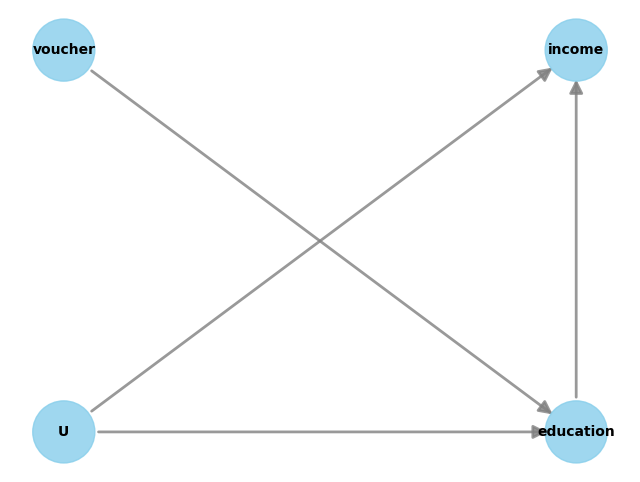

In [19]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [20]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [21]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.751306132212053
New effect:0.02419649264159742
p value:1.0



### Discrete Variables (binary treatment)

In [22]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher
education = np.where(education < education.mean(), 0, 1)

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

#### Without latent variables

- IV method only works depending on the data

In [23]:
# Build dataset
data = pd.DataFrame({
    'U': dowhy.datasets.convert_continuous_to_discrete(ability),
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': education,
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,U,voucher,education,income
0,-5,1,0,-2
1,1,3,1,16
2,-2,3,0,5
3,0,2,1,14
4,-3,2,0,8


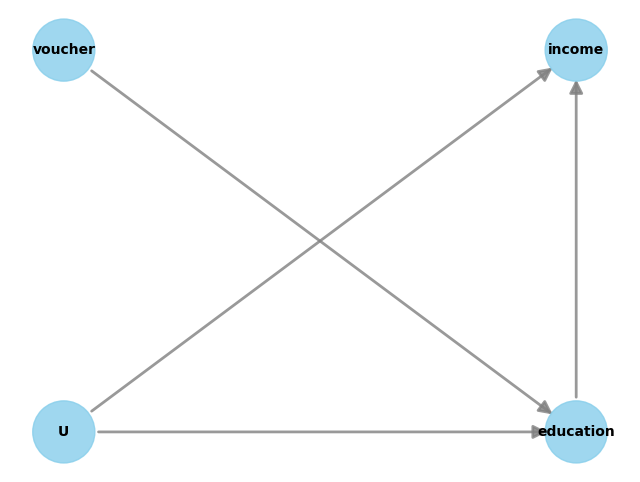

In [24]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [25]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [26]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.134781202981689
New effect:-0.041224462059262536
p value:0.84



In [27]:
# Choose the first estimand: using Propensity Score Stratification

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.8543488490522213
New effect:-0.02095748807035348
p value:0.88



In [28]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

#### `Ability` as an unobserved confounder

- IV method works depending on the data
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [29]:
# Build dataset
data = pd.DataFrame({
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': education,
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,voucher,education,income
0,1,0,-2
1,3,1,16
2,3,0,5
3,2,1,14
4,2,0,8


c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


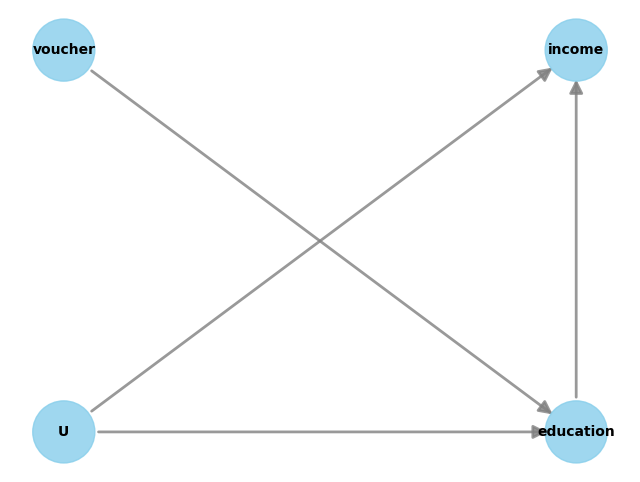

In [30]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [31]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [32]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

### All binary variables

In [33]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education
         
ability, voucher, education, income = map(lambda x: np.where(x < x.mean(), 0, 1), [ability, voucher, education, income])

#### Without latent variables

- In this scenario the IV method worked for some reason

In [34]:
# Build dataset
data = pd.DataFrame({
    'U': dowhy.datasets.convert_continuous_to_discrete(ability),
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': education,
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,U,voucher,education,income
0,0,0,0,0
1,1,1,1,1
2,0,1,1,1
3,0,0,0,0
4,0,0,0,0


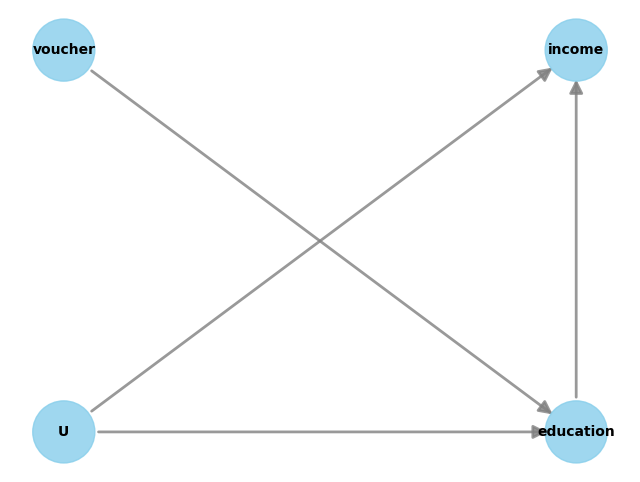

In [35]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [36]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [37]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:0.6955082602165854
New effect:0.0012463169019698629
p value:0.96



In [38]:
# Choose the first estimand: using Propensity Score Stratification

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:0.6949419858360265
New effect:0.0006486473819935487
p value:0.92



In [39]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

#### `Ability` as an unobserved confounder

- In this scenario the IV method works for some reason
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [40]:
# Build dataset
data = pd.DataFrame({
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,voucher,education,income
0,0,0,0
1,1,1,1
2,1,1,1
3,0,0,0
4,0,0,0


c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


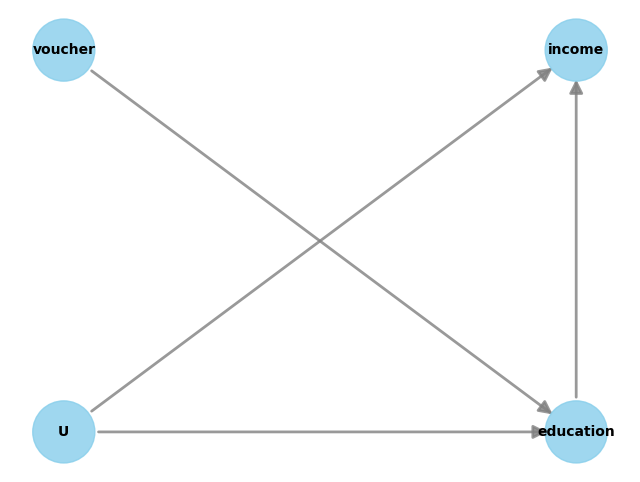

In [41]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [42]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [43]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

### Binary treatment and outcome, discrete IV and confounder

In [44]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)
ability = dowhy.datasets.convert_continuous_to_discrete(ability)

# instrument
voucher = np.random.normal(2, 1, size=n_points)
voucher = dowhy.datasets.convert_continuous_to_discrete(voucher)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education
         
education, income = map(lambda x: np.where(x < x.mean(), 0, 1), [education, income])

#### Without latent variables

- In this scenario the IV method worked for some reason

In [45]:
# Build dataset
data = pd.DataFrame({
    'U': ability,
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,U,voucher,education,income
0,-8,2,0,0
1,2,0,0,1
2,-1,0,0,0
3,0,2,1,0
4,1,1,0,1


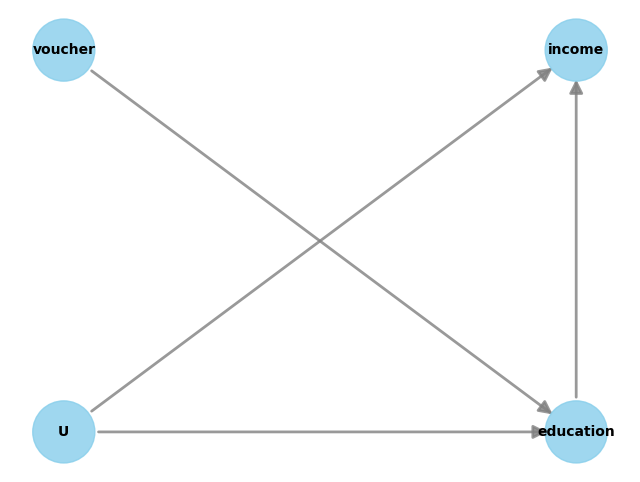

In [46]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [47]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [48]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:0.664640447598268
New effect:0.0025845824450790628
p value:0.96



In [49]:
# Choose the first estimand: using Propensity Score Stratification

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:0.6108733006543776
New effect:-0.004539134037820637
p value:0.94



In [50]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

#### `Ability` as an unobserved confounder

- In this scenario the IV method works for some reason
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [51]:
# Build dataset
data = pd.DataFrame({
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,voucher,education,income
0,2,0,0
1,0,0,1
2,0,0,0
3,2,1,0
4,1,0,1


c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


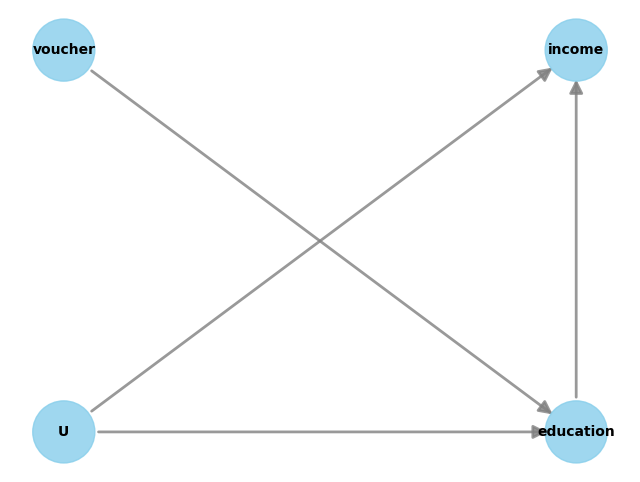

In [52]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [53]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [54]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

### Discrete Variables (binary outcome)

In [55]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)
ability = dowhy.datasets.convert_continuous_to_discrete(ability)

# instrument
voucher = np.random.normal(2, 1, size=n_points)
voucher = dowhy.datasets.convert_continuous_to_discrete(voucher)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher
education = dowhy.datasets.convert_continuous_to_discrete(education)

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education
         
income = np.where(income < income.mean(), 0, 1)

#### Without latent variables

- In this scenario the IV method worked for some reason

In [56]:
# Build dataset
data = pd.DataFrame({
    'U': ability,
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,U,voucher,education,income
0,3,3,15,1
1,0,2,7,0
2,-1,0,2,0
3,0,2,8,1
4,-1,2,9,1


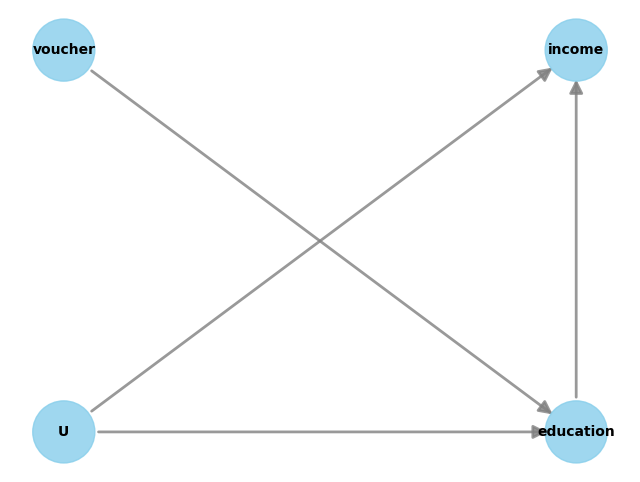

In [57]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [58]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [59]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:0.10366931519424302
New effect:0.00017466901853432416
p value:1.0



In [60]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

#### `Ability` as an unobserved confounder

- In this scenario the IV method works for some reason
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [61]:
# Build dataset
data = pd.DataFrame({
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,voucher,education,income
0,3,15,1
1,2,7,0
2,0,2,0
3,2,8,1
4,2,9,1


c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


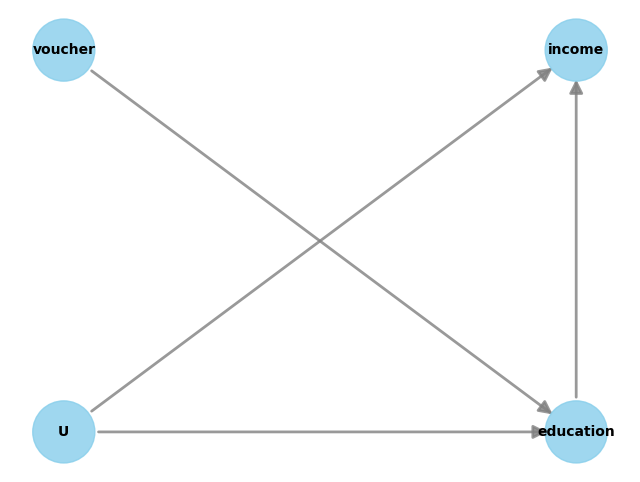

In [62]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [63]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [64]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,